# HOMEWORK ONE


In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
QUOTE_DATE = '2022-09-30'

rawdata = pd.read_excel('/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/treasury_quotes_2022-09-30 (1).xlsx',sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

PROBLEM 1)

In [4]:
metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics['TDYLD'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)

In [5]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [6]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [7]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.DataFrame(index=px.index,columns=['annual','semiannual','daily','continuous'],dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond,'semiannual'] = fsolve(pv_wrapper,.01)

ytm['annual'] = compound_rate(ytm['semiannual'],2,1)
ytm['daily'] = compound_rate(ytm['semiannual'],2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'],2,None)
ytm

,annual,semiannual,daily,continuous
KYTREASNO,,,,
207892,0.024600,0.024451,0.024303,0.024303
207774,0.024030,0.023887,0.023747,0.023746
207893,0.025178,0.025022,0.024867,0.024867
207868,0.026274,0.026103,0.025935,0.025935
207430,0.029178,0.028968,0.028761,0.028760
...,...,...,...,...
207763,0.038725,0.038357,0.037996,0.037994
207808,0.038609,0.038243,0.037884,0.037882
207849,0.038551,0.038186,0.037828,0.037826


In [8]:
COMPOUND_FREQ = 'continuous'

table = metrics.copy()
table = table[['maturity','price','coupon rate','TDYLD','ask-bid']]
table.insert(4,'ytm',ytm[COMPOUND_FREQ])
table

,maturity,price,coupon rate,TDYLD,ytm,ask-bid
KYTREASNO,,,,,,
207892,0.010951,99.973389,0.000,0.024286,0.024303,0.000111
207774,0.016427,99.961000,0.000,0.023730,0.023746,0.000167
207893,0.030116,99.925139,0.000,0.024850,0.024867,0.000306
207868,0.035592,99.907736,0.000,0.025917,0.025935,0.000361
207430,0.041068,100.568648,1.375,0.028740,0.028760,0.031250
...,...,...,...,...,...,...
207808,29.125257,66.640625,1.875,0.037857,0.037882,0.046875
207849,29.377139,72.718750,2.250,0.037800,0.037826,0.062500
207850,29.377139,62.910156,0.125,NaN,NaN,0.257812


In [9]:
idx_nominal = rawdata['ITYPE']<11
idx = rawdata[idx_nominal]['TDYLD'].isna()
if idx.any():
    table[idx]
else:
    display(f'No NaN yields.')

'No NaN yields.'

PROBLEM 2)

CASHFLOWS

In [10]:
CF = calc_cashflows(rawdata)
prices = metrics['price'][CF.index]

CFset = {'all dates, including negative YTM quotes':CF}
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.1250,0.0000,1.1250,0.0000,1.1250,0.0000,101.1250,0.0000,0.0
207850,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0625,0.0000,0.0625,0.0000,0.0625,0.0000,100.0625,0.0000,0.0


BOOTSTRAP

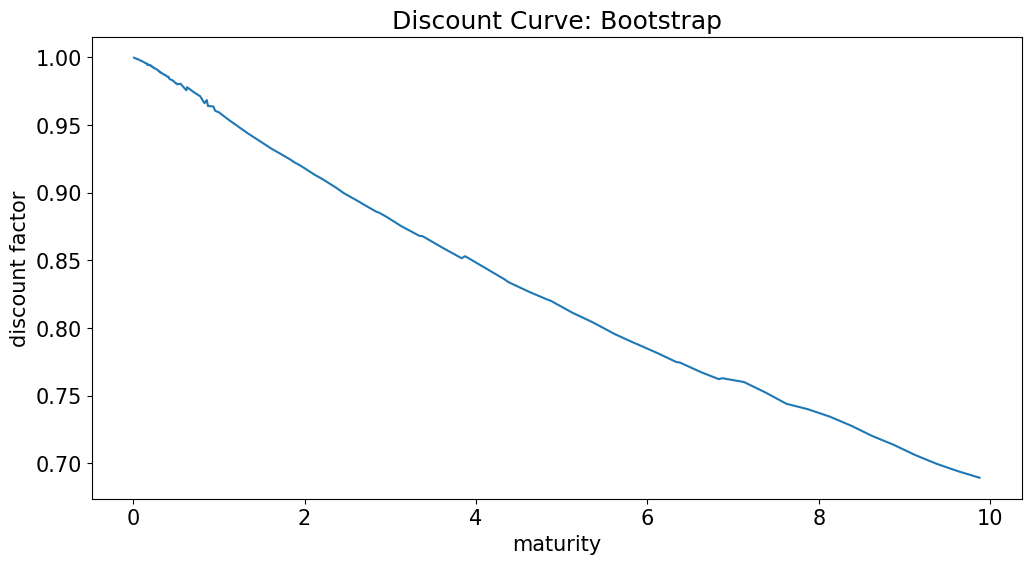

In [11]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

OLS

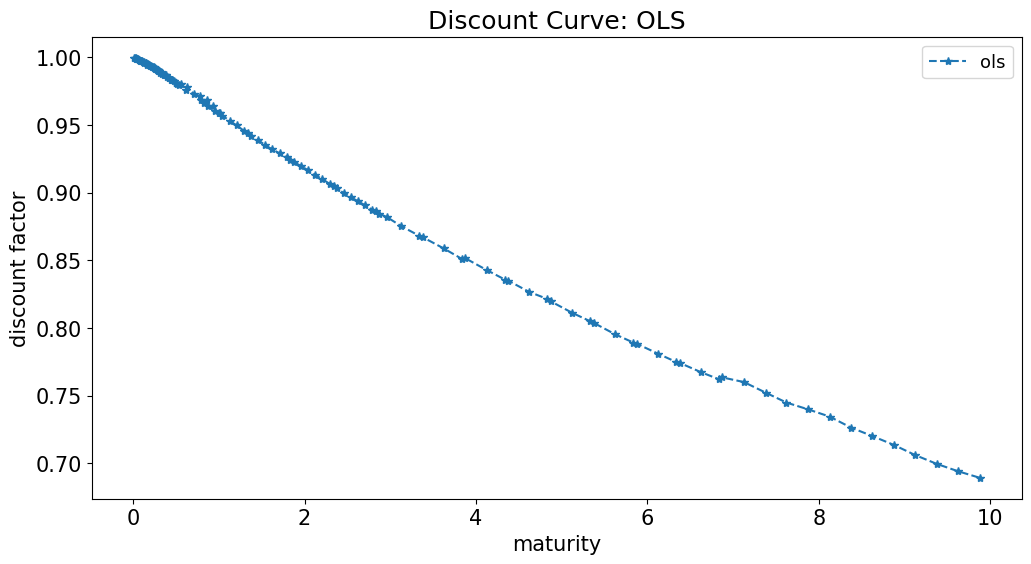

In [12]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'no non-maturity dates'
CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

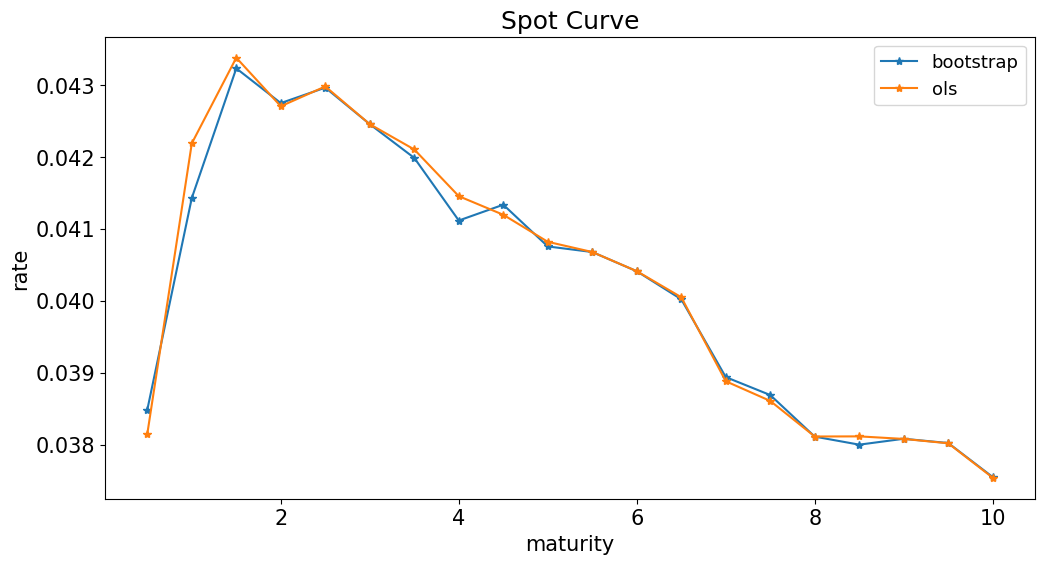

In [13]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

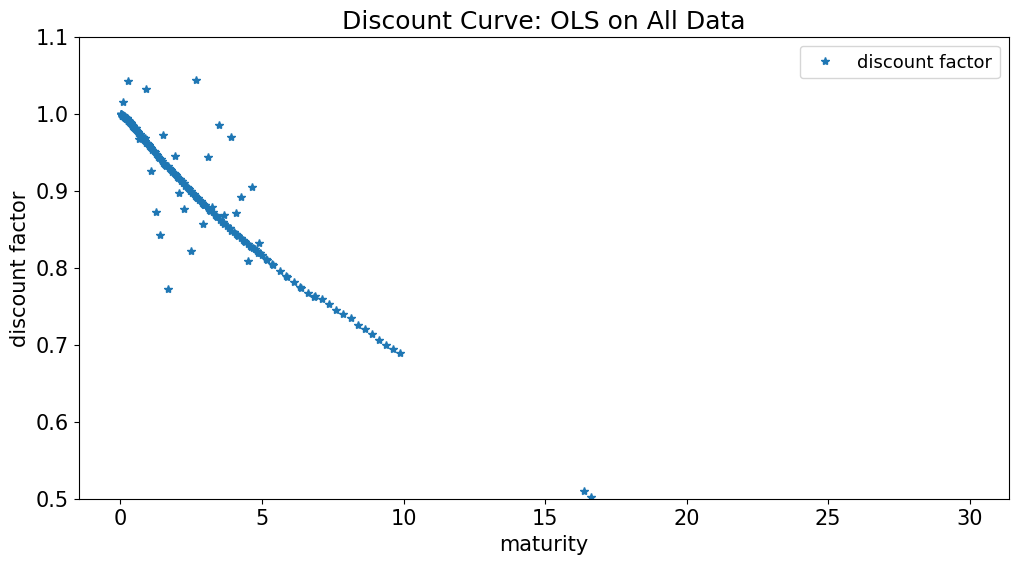

In [14]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
CFset['all dates'] = CF

prices = metrics['price'][CF.index]
params_OLS_bad = estimate_rate_curve(MODEL,CF,t_current,prices)

disc_ols_bad = pd.DataFrame({'maturity':params_OLS_bad[0], 'discount factor': params_OLS_bad[1]}).set_index('maturity')
disc_ols_bad.plot(marker='*',linestyle='',ylim=(.5,1.1),ylabel='discount factor',title='Discount Curve: OLS on All Data')
plt.show()

In [15]:
curves_ols

,bootstrap,ols
0.5,0.038484,0.038148
1.0,0.041429,0.042188
1.5,0.043232,0.043380
2.0,0.042749,0.042705
2.5,0.042964,0.042980
3.0,0.042455,0.042455
3.5,0.041986,0.042104
4.0,0.041116,0.041454
4.5,0.041335,0.041196
5.0,0.040755,0.040820
